##Preparación y exploración de datos

In [1]:
# Importar librerias (en caso de ser necesario)
!pip install pandas
!pip install numpy
!pip install opendatasets
!pip install matplotlib
!pip install scikit-learn

In [43]:
# Librerias básicas
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Librerias para importar y usar el dataset proveniente de Kaggle
import os
import opendatasets as od

# Libreria para generar variables categóricas
from sklearn.preprocessing import LabelEncoder

# K Means
from sklearn.cluster import KMeans

# DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
from sklearn.cluster import DBSCAN

# Libreria para el ajuste de hiperparámetros
from sklearn.metrics import silhouette_score, silhouette_samples

# Librerias para visualizar los mejores hiperparámetros
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer

# Libreria para ignorar los warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Obtención de Dataset de Kaggle, a partir de la descarga de este paquete mediante la libreria "opendatasets"
dataset_link = "https://www.kaggle.com/datasets/kamaumunyori/german-bank-credit-data?resource=download"
od.download(dataset_link)
os.chdir("german-bank-credit-data")
os.listdir()

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: omarguillermo
Your Kaggle Key: ··········


100%|██████████| 1.35M/1.35M [00:00<00:00, 2.37MB/s]

['German Bank Segmentation.']

In [4]:
# Carga de Datos
dataset_name = '/content/german-bank-credit-data/German Bank Segmentation./german_credit_data.csv'
df = pd.read_csv(dataset_name)

display(df.head()) # Mostrar los 5 primeros
print()
display(df.info()) # Mostrar la información del df para observar si hay filas vacías

Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  
0           1169         6             radio/TV  
1           5951        48             radio/TV  
2           2096        12            education  
3           7882        42  furniture/equipment  
4           4870        24                  car


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.2+ KB


None

In [5]:
# Visualización de los valores nulos dentro del dataset
display(df.isnull().sum())

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

In [6]:
# Imputar los valores nulos dentro de la columnas vacias usando las columnas con mejor relacion, ya que solo es viable eliminar las filas si son pocas
'''
Univariable: Usando la media/mediana/moda
Multivariable: Usando KNNImputer o IterativeImputer

Vamos a usar la imputación por moda, pero condicional
'''

saving_accounts_imputacion_condicional = df.groupby(['Sex', 'Job'])['Saving accounts'].transform(lambda x: x.fillna(x.mode()[0]))
df['Saving accounts'] = saving_accounts_imputacion_condicional

checking_account_imputacion_condicional = df.groupby(['Sex', 'Job'])['Checking account'].transform(lambda x: x.fillna(x.mode()[0]))
df['Checking account'] = checking_account_imputacion_condicional

display(df.head())
print()
display(df.info())

Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own          little           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little           little   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  
0           1169         6             radio/TV  
1           5951        48             radio/TV  
2           2096        12            education  
3           7882        42  furniture/equipment  
4           4870        24                  car


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   1000 non-null   object
 6   Checking account  1000 non-null   object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.2+ KB


None

In [7]:
# Eliminar columna "0", ya que es usada como ID y no es necesaria en el analísis que estamos haciendo
df = df.drop('Unnamed: 0', axis=1)

# Transformar la columna de "credit amount" en Euro.
TASA_FRANCO_A_EURO = 0.5113
df["Credit amount"] = (df["Credit amount"] * TASA_FRANCO_A_EURO).round(2) # <--- De Marco Alemán a Euro

display(df.head())
print()
display(df.info())

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own          little           little         597.71   
1   22  female    2     own          little         moderate        3042.75   
2   49    male    1     own          little           little        1071.68   
3   45    male    2    free          little           little        4030.07   
4   53    male    2    free          little           little        2490.03   

   Duration              Purpose  
0         6             radio/TV  
1        48             radio/TV  
2        12            education  
3        42  furniture/equipment  
4        24                  car


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               1000 non-null   int64  
 1   Sex               1000 non-null   object 
 2   Job               1000 non-null   int64  
 3   Housing           1000 non-null   object 
 4   Saving accounts   1000 non-null   object 
 5   Checking account  1000 non-null   object 
 6   Credit amount     1000 non-null   float64
 7   Duration          1000 non-null   int64  
 8   Purpose           1000 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 70.4+ KB


None

In [8]:
df_numerico = df.copy()

# Convertir en variable categórica "Sex" en binario
df_numerico["Sex"] = df_numerico["Sex"].map({"male": 1, "female": 0})

# TODO: Convertir en variables categóricas las columnas: "Housing", "Saving accounts", "Checking account" y "Purpose"
df_numerico['Housing'] = df_numerico['Housing'].map({'own': 0, 'rent': 1, 'free': 2})

mapeo_cuentas = {'little': 0, 'moderate': 1, 'quite rich': 2, 'rich': 3}
df_numerico['Saving accounts'] = df_numerico['Saving accounts'].map(mapeo_cuentas)
df_numerico['Checking account'] = df_numerico['Checking account'].map(mapeo_cuentas)

label_encoder = LabelEncoder()
df_numerico['Purpose'] = label_encoder.fit_transform(df_numerico['Purpose'])

print("Categorías de la columna 'Purpose':")
for categoria, etiqueta in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{categoria}: {etiqueta}")

print()
display(df.head()) # Imprimir los 5 primeros

Categorías de la columna 'Purpose':
business: 0
car: 1
domestic appliances: 2
education: 3
furniture/equipment: 4
radio/TV: 5
repairs: 6
vacation/others: 7



Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own          little           little         597.71   
1   22  female    2     own          little         moderate        3042.75   
2   49    male    1     own          little           little        1071.68   
3   45    male    2    free          little           little        4030.07   
4   53    male    2    free          little           little        2490.03   

   Duration              Purpose  
0         6             radio/TV  
1        48             radio/TV  
2        12            education  
3        42  furniture/equipment  
4        24                  car

In [9]:
# Estadísticas descriptivas e informaciones de todo el Dataset
display(df.describe())
print()

display(df.info())
print()

Age          Job  Credit amount     Duration
count  1000.000000  1000.000000    1000.000000  1000.000000
mean     35.546000     1.904000    1672.594210    20.903000
std      11.375469     0.653614    1443.265343    12.058814
min      19.000000     0.000000     127.820000     4.000000
25%      27.000000     2.000000     698.182500    12.000000
50%      33.000000     2.000000    1185.960000    18.000000
75%      42.000000     2.000000    2031.007500    24.000000
max      75.000000     3.000000    9420.190000    72.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               1000 non-null   int64  
 1   Sex               1000 non-null   object 
 2   Job               1000 non-null   int64  
 3   Housing           1000 non-null   object 
 4   Saving accounts   1000 non-null   object 
 5   Checking account  1000 non-null   object 
 6   Credit amount     1000 non-null   float64
 7   Duration          1000 non-null   int64  
 8   Purpose           1000 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 70.4+ KB


None

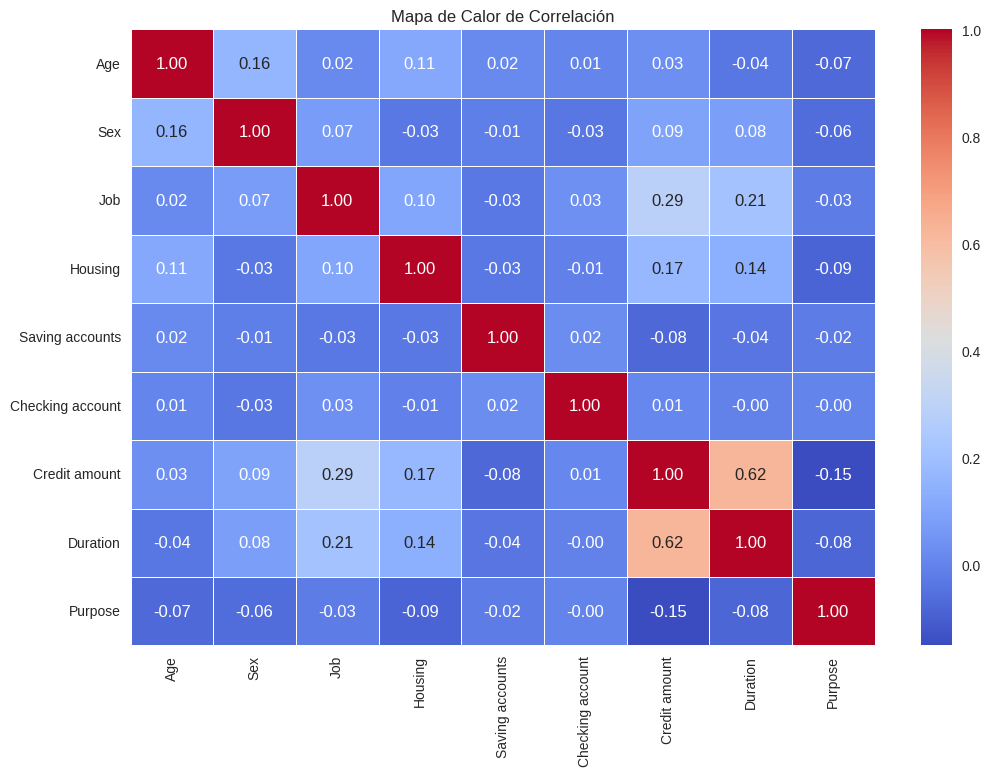

In [10]:
# Mostrar un gráfico de mapa de calor de la relación entre las variable del Dataset
matrix_de_correlacion = df_numerico.corr()

plt.figure(figsize=(12, 8))

sns.heatmap(matrix_de_correlacion, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title('Mapa de Calor de Correlación')
plt.show()

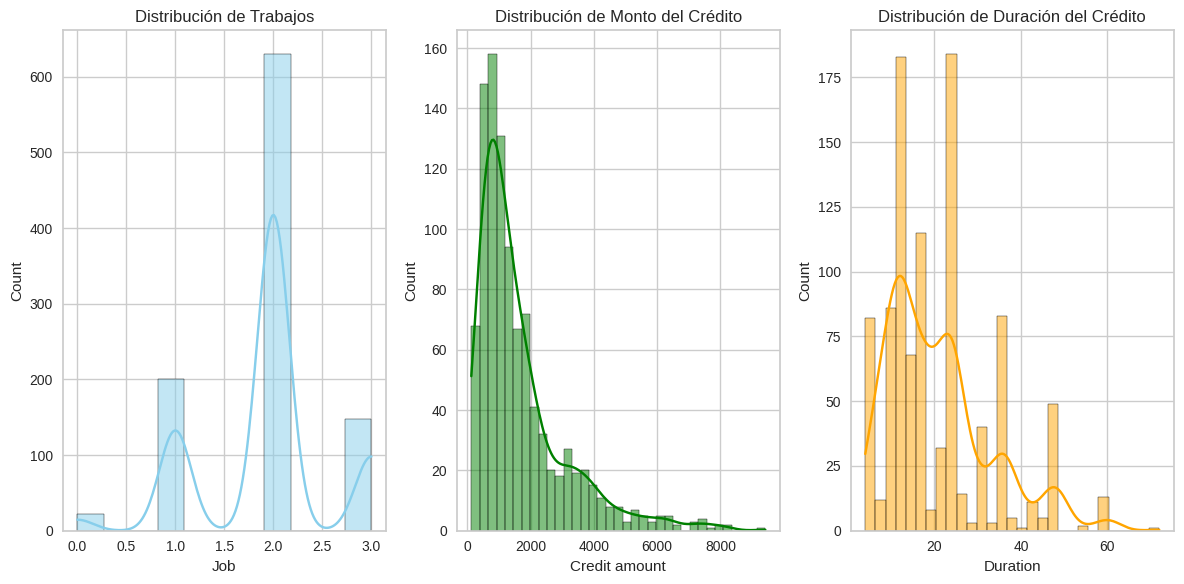

In [11]:
# Histogramas y Gráficos de Densidad
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.histplot(df_numerico['Job'], kde=True, color='skyblue')
plt.title('Distribución de Trabajos')

plt.subplot(1, 3, 2)
sns.histplot(df_numerico['Credit amount'], kde=True, color='green')
plt.title('Distribución de Monto del Crédito')

plt.subplot(1, 3, 3)
sns.histplot(df_numerico['Duration'], kde=True, color='orange')
plt.title('Distribución de Duración del Crédito')

plt.tight_layout()
plt.show()

##Selección y entrenamiento del modelo

In [12]:
# Definir las columnas columnas que vamos a usar para clusterizar
columnas_elegidas = ["Job", "Credit amount", "Duration"]
X = df.loc[:,columnas_elegidas]

In [13]:
# Definir los modelos apra ver los hiperparámetros
modelo_kmeans = KMeans(random_state=41, n_init='auto')

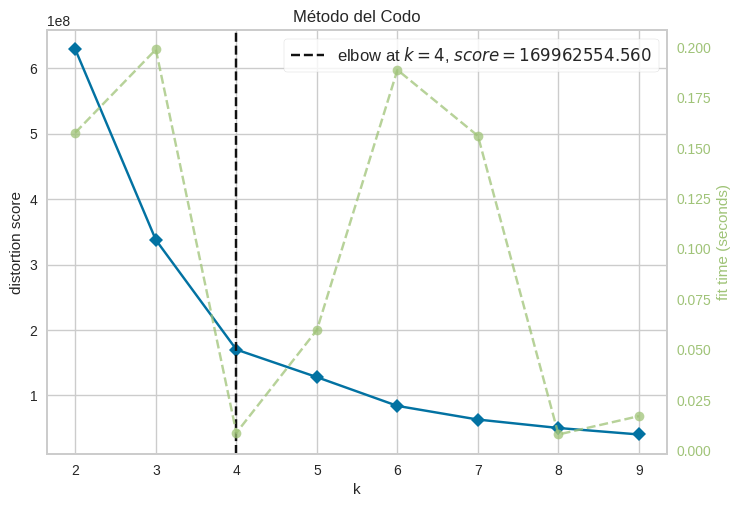


Para n = 2  de clústers, el promedio del puntaje de silueta es: 0.7222166531497787
Para n = 3  de clústers, el promedio del puntaje de silueta es: 0.6311772634916516
Para n = 4  de clústers, el promedio del puntaje de silueta es: 0.6121698691104476
Para n = 5  de clústers, el promedio del puntaje de silueta es: 0.606235432491002
Para n = 6  de clústers, el promedio del puntaje de silueta es: 0.5787855636031385
Para n = 7  de clústers, el promedio del puntaje de silueta es: 0.5687030000863766
Para n = 8  de clústers, el promedio del puntaje de silueta es: 0.5099301711082449
Para n = 9  de clústers, el promedio del puntaje de silueta es: 0.509015895410495

No. de Clústeres óptimo es: 0.7222166531497787



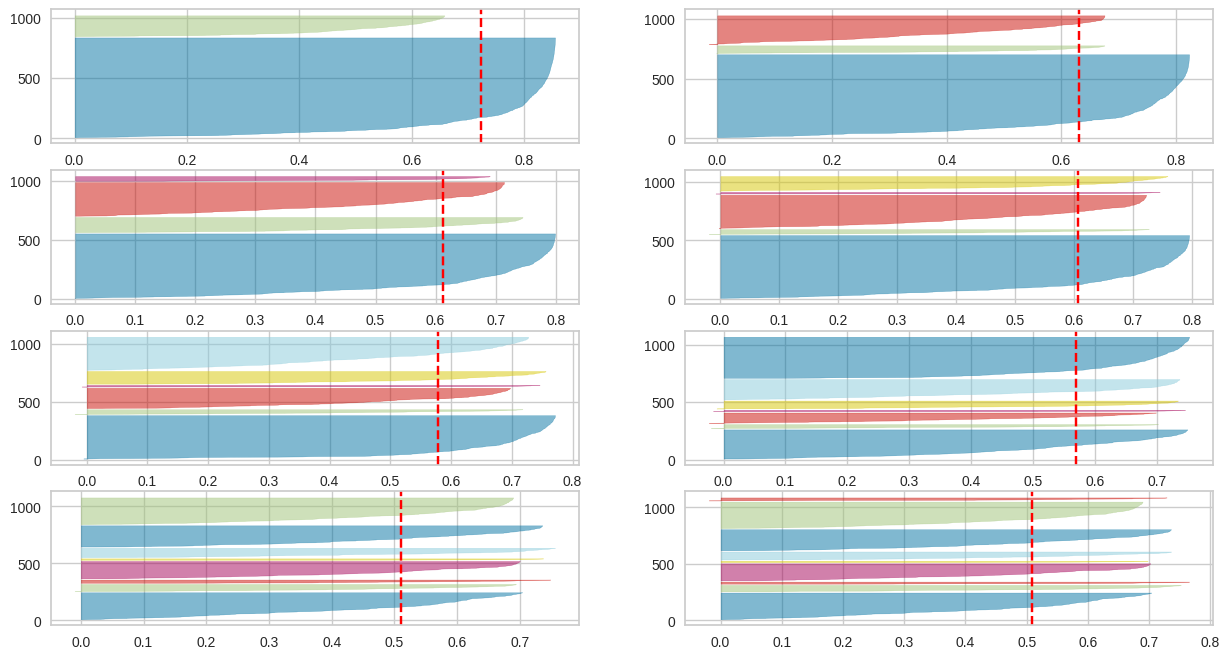

In [44]:
# TODO: Manejar hiperparámetros para K-Means y DBSCAN
'''
  Optimización del modelo del K-Means
'''

# Usar métodos del codo y marcadores como el de la silueta para elegir las mejores cantidades de clusters

# Definir el espacio de búsqueda de hiperparámetros
K = range(2, 10)

# -- Usando el método del codo --
visualizador_codo = KElbowVisualizer(modelo_kmeans, k=K, title="Método del Codo")
visualizador_codo.fit(X)
visualizador_codo.show()

print()

resultados = []
figura, ax = plt.subplots(math.ceil(len(K)/2), 2, figsize=(15,8))
# -- Usando el método de la silueta --
for k in K:
  modelo = KMeans(n_clusters=k, random_state=41, n_init='auto')
  labels = modelo.fit_predict(X)
  promedio_silueta = silhouette_score(X, labels)
  print("Para n =", k," de clústers, el promedio del puntaje de silueta es:", promedio_silueta)
  resultados.append(promedio_silueta)
  q, mod = divmod(k, 2)
  visualizer = SilhouetteVisualizer(modelo, colors='yellowbrick', ax=ax[q-1][mod])
  visualizer.fit(X)

print()
print(f"No. de Clústeres óptimo es: {max(resultados)}\n")

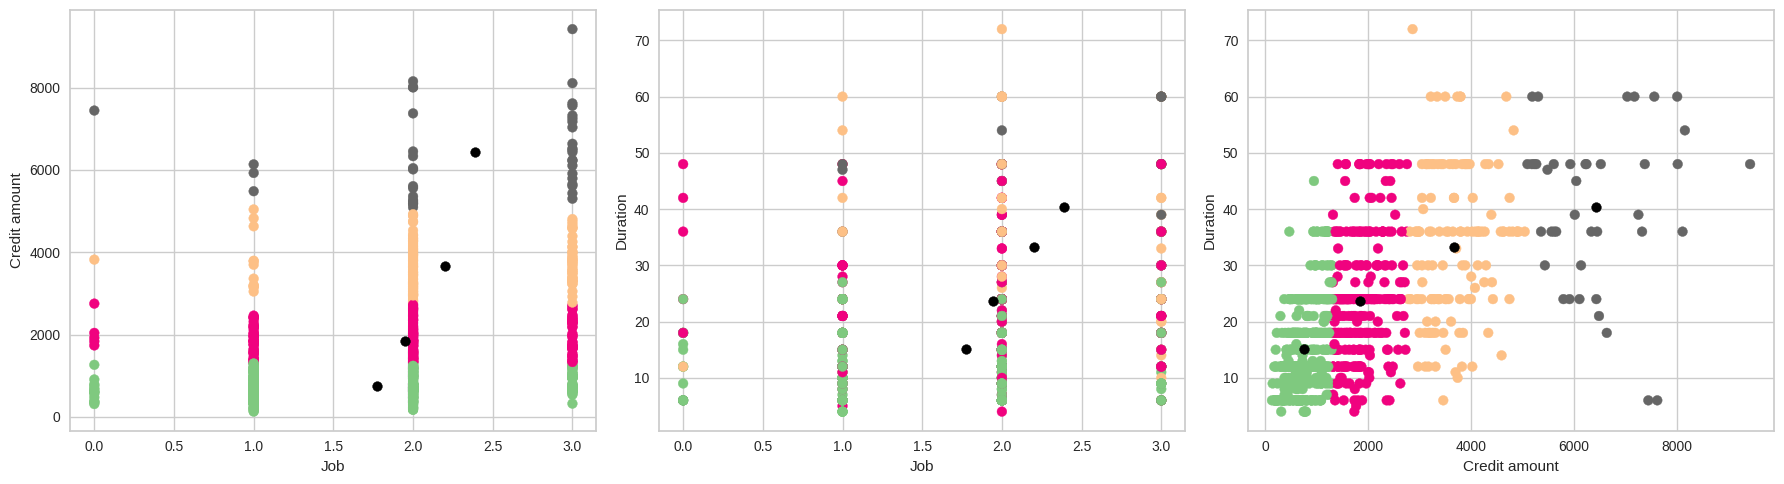

In [45]:
modelo = KMeans(n_clusters=4, random_state=41, n_init='auto').fit(X)

prediccion = modelo.predict(X)

# Definir el tamaño de la figura
plt.figure(figsize=(18, 5))

# Scatter plot entre "Job" y "Credir amount"
plt.subplot(1, 3, 1)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=prediccion, cmap=cm.Accent)
for centroides in modelo.cluster_centers_:
    plt.scatter(centroides[0], centroides[1], marker='o', c='black')
plt.xlabel("Job")
plt.ylabel("Credit amount")

# Scatter plot entre "Job" y "Duration"
plt.subplot(1, 3, 2)
plt.scatter(X.iloc[:, 0], X.iloc[:, 2], c=prediccion, cmap=cm.Accent)
for centroides in modelo.cluster_centers_:
    plt.scatter(centroides[0], centroides[2], marker='o', c='black')
plt.xlabel("Job")
plt.ylabel("Duration")

# Scatter plot entre "Credit amount" y "Duration"
plt.subplot(1, 3, 3)
plt.scatter(X.iloc[:, 1], X.iloc[:, 2], c=prediccion, cmap=cm.Accent)
for centroides in modelo.cluster_centers_:
    plt.scatter(centroides[1], centroides[2], marker='o', c='black')
plt.xlabel("Credit amount")
plt.ylabel("Duration")

# Mostrar el gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
'''
  Optimización del modelo del DBSCAN
'''

# Definir el rango de búsqueda de hiperparámetros para epsilon y min_samples
rango_eps = np.linspace(0.1, 1, 10)
rango_min_muestras = range(2, 10)

# Usar métodos de evaluación como la silueta para elegir los mejores hiperparámetros
mejor_puntaje = -1
mejor_eps = None # Distancia máxima entre dos muestras para que se consideren vecinas. Es decir, distancia usada de parámetro para que dos puntos se consideren parte del mismo clúster.
mejor_min_muestras = None # Número mínimo de muestras que deben estar dentro de la distancia epsilon para que un punto se considere un núcleo.

for eps in rango_eps:
    for min_muestras in rango_min_muestras:
        dbscan = DBSCAN(eps=eps, min_samples=min_muestras)
        etiquetas = dbscan.fit_predict(X)
        if len(set(etiquetas)) > 1:  # Al menos dos clústeres deben ser identificados
            silueta_promedio = silhouette_score(X, etiquetas)
            if silueta_promedio > mejor_puntaje:
                mejor_puntaje = silueta_promedio
                mejor_eps = eps
                mejor_min_muestras = min_muestras

print(f"El mejor valor para epsilon es: {mejor_eps}")
print(f"El mejor valor para min_samples es: {mejor_min_muestras}")
print(f"El mejor valor de silueta es: {mejor_puntaje}")

El mejor valor para epsilon es: 1.0
El mejor valor para min_samples es: 3
El mejor valor de silueta es: -0.28444867354558495


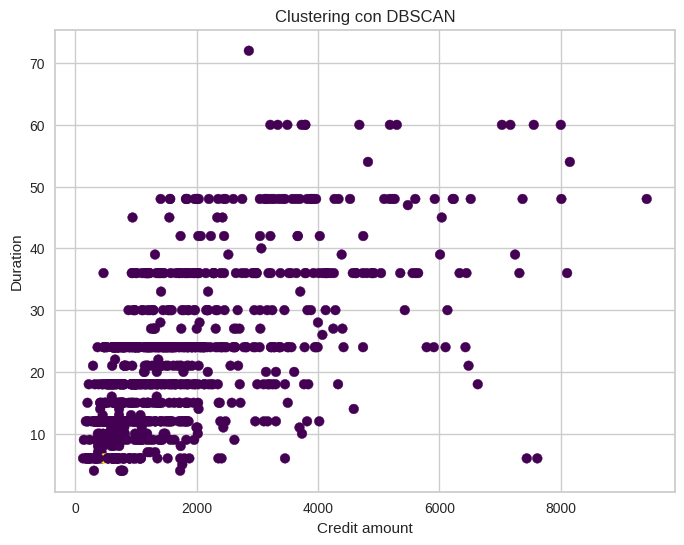

In [47]:
dbscan = DBSCAN(eps=mejor_eps, min_samples=mejor_min_muestras)
etiquetas = dbscan.fit_predict(X)

# Crear un gráfico para visualizar los resultados del clustering
plt.figure(figsize=(8, 6))

# Asignar colores a las etiquetas de clustering
colores = etiquetas.astype(float)

# Graficar los puntos en función de las características
plt.scatter(X.iloc[:, 1], X.iloc[:, 2], c=colores, cmap='viridis')

# Etiquetas de los ejes
plt.xlabel('Credit amount')
plt.ylabel('Duration')

# Título del gráfico
plt.title('Clustering con DBSCAN')

# Mostrar el gráfico
plt.show()


##Aplicación y relevancia